In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter  
drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'

In [15]:
cell_types = []
sign_map = {'FS':'exc', 'RS':'inh'}
cell_idxs = np.arange(len(cell_table))
for c_idx in cell_idxs:#[-k:]:
    c_type = ''
    c_type += sign_map[cell_table.RSFS.values[c_idx]] + '_'
    c_type += cell_table.structure.values[c_idx] + '_'
    if str.startswith(cell_table.structure.values[c_idx],'VIS'):
        if cell_table.depth.values[c_idx] > -920:
            c_type += '1'
        elif cell_table.depth.values[c_idx] > -960:
            c_type += '4'
        else:
            c_type += '5'
    cell_types.append(c_type)
print len(cell_types), np.unique(cell_types)

71 ['exc_VISp_1' 'exc_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_5']


In [16]:
np.savez('cell_types71',cell_types=cell_types)

In [1]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Add,add, Maximum, Layer, Dense, Lambda
from keras import Sequential
from keras.regularizers import Regularizer
from keras.callbacks import LearningRateScheduler
from scipy.special import gamma
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [22]:
D = np.load('drifting_gratings_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = 0.01
D = np.load('cell_types71.npz')
cell_types = D['cell_types']

ord_idxs = np.argsort(CCmaxs)[-30:]
ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-4:])) #these particular cells caused problems
print CCmaxs[ord_idxs[-1]]

0.9199474554408273


In [ ]:
d = 30
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

In [4]:
# individual parameter sets
def construct_GLM_mat(flat_stimulus, binned_spikes, d, spk_filts=None):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     print("N,T", (N,T))
#     print("M,T", (M,T))
    if spk_filts is not None:
        X_dsn = np.empty((T-d,M*d+N*spk_filts.shape[1]))
    else:
        X_dsn = np.empty((T-d,M*d+N*d))
    for t in range(T-d):
        X_dsn[t,:M*d] = np.fliplr(flat_stimulus[:,t:t+d]).reshape((1,-1))  #stimulus inputs
    if spk_filts is not None:
        for i in range(N):
            for j in range(spk_filts.shape[1]):
                X_dsn[:,M*d+i*spk_filts.shape[1]+j] = np.convolve(binned_spikes[i,:],spk_filts[:,j],mode='valid')[:T-d]
    else:
        for t in range(T-d):
            X_dsn[t,M*d:] = np.fliplr(binned_spikes[:,t:t+d]).reshape((1,-1)) #spike inputs
    return X_dsn


def exp_decay(t):
    initial_lrate = 1e-4
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate


# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    
    train_end_ind = 3*T/4-10*d
    val_start_ind = 3*T/4+10*d
    
    F = np.empty((N,M,d)) # stimulus filters
    W = np.empty((N,d))  # spike train filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    val_losses = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    for i in range(N):
        Xdsn = construct_GLM_mat(stimulus[:,:train_end_ind],np.expand_dims(spikes[i,:train_end_ind],0), d)
        y = spikes[i,d:train_end_ind]
        
        Xdsn_val = construct_GLM_mat(stimulus[:,val_start_ind:],np.expand_dims(spikes[i,val_start_ind:],0), d)
        y_val = spikes[i,val_start_ind+d:]
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-4))
        model.fit(x=Xdsn,y=y,batch_size=5000,epochs=12,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d].reshape((M,d))
        W[i,:] = np.squeeze(p[M*d:])
        b[i] = model.get_weights()[1]
        train_losses[i] = model.evaluate(x=Xdsn,y=y,verbose=0)
        val_losses[i] = model.evaluate(x=Xdsn_val,y=y_val,verbose=0)
        models.append(model)
    return (F,W,b,losses,val_losses,models)


In [106]:
# individual parameter sets

def batch_generator(flat_stimulus, binned_spikes, d, batch_size=5000):
    d1,d2 = d
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    k=d2
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[idxs]
        X = np.empty((M*d1+d2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,idx-d1:idx],[1,-1]))
            X[M*d1:,i] = np.fliplr(np.reshape(binned_spikes[idx-d2:idx],[1,-1]))
        k = k+batch_size
        if k>T:
            k=d2
        yield X.T, y

def exp_decay(t):
    initial_lrate = 1e-2
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    
    train_end_ind = 280000 #3*T/4-10*d
    val_start_ind = 280000 #3*T/4+10*d
    bs = 3000
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = np.empty((N,d[1]))  # spike train filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    for i in range(N):
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d[0]+d[1],use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator(stimulus[:,:train_end_ind],spikes[i,:train_end_ind], d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = (train_end_ind-d[1])/bs+1,
                            epochs=10,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d[0]].reshape((M,d[0]))
        W[i,:] = np.squeeze(p[M*d[0]:])
        b[i] = model.get_weights()[1]
#         print spikes[i,val_start_ind+d:].shape, model.predict_generator(val_gen,steps=2).shape
        train_losses[i] = model.evaluate_generator(train_gen,steps=(train_end_ind-d[1])/bs)
        train_corrs[i] = np.corrcoef(spikes[i,d[1]:train_end_ind],y=model.predict_generator(train_gen,steps=(train_end_ind-d[1])/bs+1).squeeze())[0,1]
        val_gen = batch_generator(stimulus[:,val_start_ind:],spikes[i,val_start_ind:], d,batch_size=T-val_start_ind-d[1])
        val_losses[i] = model.evaluate_generator(val_gen,steps=1)
        val_corrs[i] = np.corrcoef(spikes[i,val_start_ind+d[1]:],y=model.predict_generator(val_gen,steps=2).squeeze())[0,1]
        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [107]:
d=[1,30]
# (F,W,b,losses,val_losses,models) = GLM_indiv_fit(stim_array,np.expand_dims(reduced_binned_spikes[-1,:],0),d, bin_len)
(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit(mod_stim,binned_spikes[ord_idxs,:],d, bin_len)


Epoch 1/10
 - 7s - loss: 0.7237
Epoch 2/10
 - 2s - loss: 0.5969
Epoch 3/10
 - 2s - loss: 0.5807
Epoch 4/10
 - 2s - loss: 0.5715
Epoch 5/10
 - 2s - loss: 0.5655
Epoch 6/10
 - 2s - loss: 0.5616
Epoch 7/10
 - 2s - loss: 0.5592
Epoch 8/10
 - 2s - loss: 0.5578
Epoch 9/10
 - 2s - loss: 0.5570
Epoch 10/10
 - 2s - loss: 0.5565
Epoch 1/10
 - 7s - loss: 0.1588
Epoch 2/10
 - 2s - loss: 0.1397
Epoch 3/10
 - 2s - loss: 0.1364
Epoch 4/10
 - 2s - loss: 0.1344
Epoch 5/10
 - 2s - loss: 0.1330
Epoch 6/10
 - 2s - loss: 0.1321
Epoch 7/10
 - 2s - loss: 0.1314
Epoch 8/10
 - 2s - loss: 0.1308
Epoch 9/10
 - 2s - loss: 0.1304
Epoch 10/10
 - 2s - loss: 0.1302
Epoch 1/10
 - 7s - loss: 0.2292
Epoch 2/10
 - 2s - loss: 0.2152
Epoch 3/10
 - 2s - loss: 0.2131
Epoch 4/10
 - 2s - loss: 0.2122
Epoch 5/10
 - 2s - loss: 0.2118
Epoch 6/10
 - 2s - loss: 0.2116
Epoch 7/10
 - 2s - loss: 0.2115
Epoch 8/10
 - 2s - loss: 0.2115
Epoch 9/10
 - 2s - loss: 0.2115
Epoch 10/10
 - 2s - loss: 0.2114
Epoch 1/10
 - 7s - loss: 0.0769
Epoch

 - 2s - loss: 0.2630
Epoch 7/10
 - 2s - loss: 0.2630
Epoch 8/10
 - 2s - loss: 0.2629
Epoch 9/10
 - 2s - loss: 0.2629
Epoch 10/10
 - 2s - loss: 0.2629
Epoch 1/10
 - 8s - loss: 0.4376
Epoch 2/10
 - 2s - loss: 0.3497
Epoch 3/10
 - 2s - loss: 0.3281
Epoch 4/10
 - 2s - loss: 0.3196
Epoch 5/10
 - 2s - loss: 0.3163
Epoch 6/10
 - 2s - loss: 0.3151
Epoch 7/10
 - 2s - loss: 0.3146
Epoch 8/10
 - 2s - loss: 0.3144
Epoch 9/10
 - 2s - loss: 0.3143
Epoch 10/10
 - 2s - loss: 0.3142


In [108]:
np.savez('drifting_gratings_indivfit1_keras',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)


In [109]:
#parameter sets shared across predefined classes

def batch_generator_shared(flat_stimulus, binned_spikes, d,neuron=None, batch_size=5000):
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    d1,d2 = d
    if len(binned_spikes.shape)==1:
        binned_spikes = np.expand_dims(binned_spikes,0)
    (N,T) = binned_spikes.shape
    k=d2
    if neuron is None:
        neur = 0
    else:
        neur = neuron
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[neur,idxs]
        X = np.empty((M*d1+d2+2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,idx-d1:idx],[1,-1]))
            X[M*d1,i] = 1
            X[M*d1+1:-1,i] = np.fliplr(np.reshape(binned_spikes[neur,idx-d2:idx],[1,-1]))
            X[-1,i] = neur
        k = k+batch_size
        if k>T:
            k=d2
            if neuron is None:
                neur+=1
                if neur==N:
                    neur = 0
        yield X.T, y


class GatedDense(Layer):

    def __init__(self, neuron, output_dim, **kwargs):
        self.neuron = neuron
        self.output_dim = output_dim
        super(GatedDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.output_dim, 1), initializer='glorot_uniform',
                                      trainable=True)
        super(GatedDense, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.expand_dims(K.switch(K.equal(float(self.neuron),x[:,-1]),K.squeeze(K.dot(x[:,:self.output_dim],self.kernel),1),K.zeros_like(x[:,-1])))


    def compute_output_shape(self, input_shape):
        return (input_shape[0],1)

def exp_decay(t):
    initial_lrate = 2e-3
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate


# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_shared_fit(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    train_end_ind = 280000 # 3*T/4-10*d
    val_start_ind = 280000 # 3*T/4+10*d
    bs = 2000
    
    classes = np.unique(cell_types)
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = {}
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    for cls in classes:
        # construct GLM model and return fit
        cls_idxs = np.squeeze(np.argwhere(cell_types==cls))
        cls_spikes = spikes[cls_idxs,:]
        print cls, cls_idxs.size
        inp = Input(shape = (M*d[0]+d[1]+2,))
        x = []
        for idx in range(cls_idxs.size):
            x.append(GatedDense(idx,M*d[0]+1)(inp))
        a = Lambda(lambda val: val[:,M*d[0]+1:-1])(inp)
        x.append(Dense(1,use_bias=False)(a))
        x = Add()(x)
        out = Lambda(lambda val: fs[f](val)*bin_len)(x)
        model = Model(inputs=[inp],outputs=[out])
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator_shared(stimulus[:,:train_end_ind],cls_spikes[:,:train_end_ind], d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = ((train_end_ind-d[1])/bs+1)*cls_idxs.size,
                            epochs=10,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        p = model.get_weights()
        for idx,i in enumerate(cls_idxs):
            F[i,:,:] = p[idx][:-1].reshape((M,d[0]))
            b[i] = p[idx][-1]
            train_gen = batch_generator_shared(stimulus[:,:train_end_ind],cls_spikes[:,:train_end_ind], d, neuron = idx,batch_size=train_end_ind-d[1])
            train_losses[i] = model.evaluate_generator(train_gen,steps=1)
            train_corrs[i] = np.corrcoef(spikes[i,d[1]:train_end_ind],y=model.predict_generator(train_gen,steps=2).squeeze())[0,1]
            val_gen = batch_generator_shared(stimulus[:,val_start_ind:],cls_spikes[:,val_start_ind:], d, neuron = idx, batch_size=T-val_start_ind-d[1])
            val_losses[i] = model.evaluate_generator(val_gen,steps=1)
            val_corrs[i] = np.corrcoef(spikes[i,val_start_ind+d[1]:],y=model.predict_generator(val_gen,steps=2).squeeze())[0,1]
        W[cls] = p[-1]

        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [110]:
(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_shared_fit(mod_stim,binned_spikes[ord_idxs,:],d, bin_len,cell_types=cell_types[ord_idxs])


exc_VISp_1 3
Epoch 1/10
 - 14s - loss: 0.2170
Epoch 2/10
 - 8s - loss: 0.1953
Epoch 3/10
 - 8s - loss: 0.1918
Epoch 4/10
 - 8s - loss: 0.1902
Epoch 5/10
 - 8s - loss: 0.1895
Epoch 6/10
 - 8s - loss: 0.1891
Epoch 7/10
 - 8s - loss: 0.1888
Epoch 8/10
 - 8s - loss: 0.1887
Epoch 9/10
 - 8s - loss: 0.1885
Epoch 10/10
 - 8s - loss: 0.1884
exc_VISp_5 2
Epoch 1/10
 - 11s - loss: 0.8586
Epoch 2/10
 - 5s - loss: 0.5550
Epoch 3/10
 - 5s - loss: 0.5304
Epoch 4/10
 - 5s - loss: 0.5133
Epoch 5/10
 - 5s - loss: 0.5015
Epoch 6/10
 - 5s - loss: 0.4929
Epoch 7/10
 - 5s - loss: 0.4860
Epoch 8/10
 - 5s - loss: 0.4803
Epoch 9/10
 - 5s - loss: 0.4753
Epoch 10/10
 - 5s - loss: 0.4709
inh_VISp_1 4
Epoch 1/10
 - 17s - loss: 0.1304
Epoch 2/10
 - 11s - loss: 0.1197
Epoch 3/10
 - 11s - loss: 0.1147
Epoch 4/10
 - 15s - loss: 0.1115
Epoch 5/10
 - 13s - loss: 0.1097
Epoch 6/10
 - 11s - loss: 0.1087
Epoch 7/10
 - 10s - loss: 0.1082
Epoch 8/10
 - 11s - loss: 0.1079
Epoch 9/10
 - 11s - loss: 0.1077
Epoch 10/10
 - 11s -

In [111]:
np.savez('driftinggs_shared_run1',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)

In [112]:
# individual parameter sets

def batch_generator_noW(flat_stimulus, binned_spikes, d, batch_size=5000):
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    k=d
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[idxs]
        X = np.empty((M*d,idxs.size))
        for i,idx in enumerate(idxs):
            X[:,i] = np.fliplr(np.reshape(flat_stimulus[:,idx-d:idx],[1,-1]))
        k = k+batch_size
        if k>T:
            k=d
        yield X.T, y

def exp_decay(t):
    initial_lrate = 2e-3
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit_noW(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    
    train_end_ind = 280000 #3*T/4-10*d
    val_start_ind = 280000 #3*T/4+10*d
    bs = 3000
    
    F = np.empty((N,M,d)) # stimulus filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    for i in range(N):
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d,use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator_noW(stimulus[:,:train_end_ind],spikes[i,:train_end_ind], d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = (train_end_ind-d)/bs+1,
                            epochs=10,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        p = model.get_weights()[0]
        F[i,:,:] = p.reshape((M,d))
        b[i] = model.get_weights()[1]
#         print spikes[i,val_start_ind+d:].shape, model.predict_generator(val_gen,steps=2).shape
        train_losses[i] = model.evaluate_generator(train_gen,steps=(train_end_ind-d)/bs)
        train_corrs[i] = np.corrcoef(spikes[i,d:train_end_ind],y=model.predict_generator(train_gen,steps=(train_end_ind-d)/bs+1).squeeze())[0,1]
        val_gen = batch_generator_noW(stimulus[:,val_start_ind:],spikes[i,val_start_ind:], d,batch_size=T-val_start_ind-d)
        val_losses[i] = model.evaluate_generator(val_gen,steps=1)
        val_corrs[i] = np.corrcoef(spikes[i,val_start_ind+d:],y=model.predict_generator(val_gen,steps=2).squeeze())[0,1]
        models.append(model)
    return (F,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [113]:
d = 1
(F,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit_noW(mod_stim,binned_spikes[ord_idxs,:],d, bin_len)


Epoch 1/10
 - 8s - loss: 1.0072
Epoch 2/10
 - 1s - loss: 0.9435
Epoch 3/10
 - 1s - loss: 0.8892
Epoch 4/10
 - 1s - loss: 0.8429
Epoch 5/10
 - 1s - loss: 0.8038
Epoch 6/10
 - 1s - loss: 0.7708
Epoch 7/10
 - 1s - loss: 0.7434
Epoch 8/10
 - 1s - loss: 0.7207
Epoch 9/10
 - 1s - loss: 0.7020
Epoch 10/10
 - 1s - loss: 0.6866
Epoch 1/10
 - 8s - loss: 0.1925
Epoch 2/10
 - 1s - loss: 0.1881
Epoch 3/10
 - 1s - loss: 0.1841
Epoch 4/10
 - 1s - loss: 0.1805
Epoch 5/10
 - 1s - loss: 0.1773
Epoch 6/10
 - 1s - loss: 0.1744
Epoch 7/10
 - 1s - loss: 0.1719
Epoch 8/10
 - 1s - loss: 0.1697
Epoch 9/10
 - 1s - loss: 0.1677
Epoch 10/10
 - 1s - loss: 0.1660
Epoch 1/10
 - 8s - loss: 0.2568
Epoch 2/10
 - 1s - loss: 0.2467
Epoch 3/10
 - 1s - loss: 0.2398
Epoch 4/10
 - 1s - loss: 0.2351
Epoch 5/10
 - 1s - loss: 0.2320
Epoch 6/10
 - 1s - loss: 0.2299
Epoch 7/10
 - 1s - loss: 0.2285
Epoch 8/10
 - 1s - loss: 0.2274
Epoch 9/10
 - 1s - loss: 0.2267
Epoch 10/10
 - 1s - loss: 0.2260
Epoch 1/10
 - 8s - loss: 0.0803
Epoch

 - 1s - loss: 0.2879
Epoch 7/10
 - 1s - loss: 0.2831
Epoch 8/10
 - 1s - loss: 0.2797
Epoch 9/10
 - 1s - loss: 0.2772
Epoch 10/10
 - 1s - loss: 0.2754
Epoch 1/10
 - 9s - loss: 0.4830
Epoch 2/10
 - 1s - loss: 0.4595
Epoch 3/10
 - 1s - loss: 0.4408
Epoch 4/10
 - 1s - loss: 0.4254
Epoch 5/10
 - 1s - loss: 0.4127
Epoch 6/10
 - 1s - loss: 0.4025
Epoch 7/10
 - 1s - loss: 0.3941
Epoch 8/10
 - 1s - loss: 0.3874
Epoch 9/10
 - 1s - loss: 0.3819
Epoch 10/10
 - 1s - loss: 0.3775


In [114]:
np.savez('driftinggs_noW_run1',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)

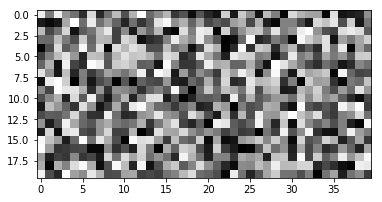

In [55]:
plt.imshow(np.reshape(F[-3,:,0],[20,40]),cmap='gray')

['inh_VISp_5' 'inh_VISp_5' 'exc_VISp_1' 'inh_VISp_4' 'inh_VISp_5'
 'inh_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_4' 'inh_VISp_4'
 'inh_VISp_5' 'inh_VISp_5' 'exc_VISp_1' 'inh_VISp_5' 'exc_VISp_5'
 'inh_VISp_4' 'exc_VISp_1' 'exc_VISp_1' 'inh_VISp_4' 'inh_VISp_5'
 'inh_VISp_4' 'inh_VISp_1' 'inh_VISp_5' 'inh_VISp_5' 'inh_VISp_4'
 'inh_VISp_5' 'exc_VISp_5' 'inh_VISp_5' 'inh_VISp_5' 'exc_VISp_5']
exc_VISp_1


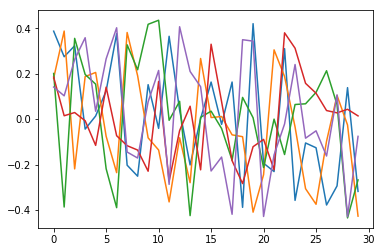

In [60]:
i=2
print cell_types[cell_idxs[-k:]]
cell_idx = cell_idxs[-k:][i]
print cell_types[cell_idx]
# plt.plot(W[cell_types[cell_idx]])
plt.plot(np.squeeze(W.values()).T)
# plt.plot(reduced_binned_spikes[-1,:])

In [4]:
D = np.load('movie_data.npz')
binned_spikes = D['binned_spikes']
stim_array = D['stim_array']


In [11]:
binned_spikes = np.expand_dims(np.loadtxt('binned_spikes_cell_2.txt',delimiter=','),0)
stim_array = np.expand_dims(np.loadtxt('binned_stim_cell_2.txt',delimiter=','),0)

In [22]:
np.savez('state_save',binned_spikes=binned_spikes, stim_array=stim_array, cell_types=cell_types)

Text(0,0.5,'training loss - unique parameters')

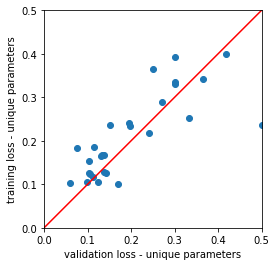

In [54]:
D = np.load('param_nonshared_run1.npz')
pts = [0,0.5]
plt.scatter(val_losses, losses)
plt.plot(pts,pts,'r')
plt.plot
plt.axis('square')
plt.xlim(pts)
plt.ylim(pts)
plt.xlabel('validation loss - unique parameters')
plt.ylabel('training loss - unique parameters')

In [18]:
print models[0].metrics_names

['loss']
